In [303]:
# conda create -n [이름] python=[버젼]
# conda active [이름]

# conda deactive
# conda remove -n [이름] --all

In [304]:
# 입력 -> 토큰화 및 시퀀스 변화 -> 패딩(고정길이화) -> 임베딩(단어->벡터화) -> 1D Convolution + poling 반복
# -> Flatten -> Dense(은닉) -> 출력(소프트맥스, 이진분류) -> 학습(Adam + binary_Crossentropy)
# -> 검증/테스트 평가 -> 시각화

- 말뭉치 로딩(nltk) 데이터 로딩
- 토큰화(빈도 기반 인덱싱) 텍스트를 숫자로 변환
- 시퀀스 패딩 고정길이 배치 구성
- 임베딩 단어를 dense vector표현 학습
- 임베딩 발전
    - 한계 : 작은데이터에서는 일반화 부족
    - 발전 : 사전학습(Word2vec), 문맥적 임베딩(BERT, GPT)


In [305]:
# 토큰화
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# sample data
texts = [
    'I really love this movie',
    'I hate this boring film',
    'love love great film'
]

# 토큰화 객체(최대 단어 10, oov 토큰 지정)
tokenizer = Tokenizer(num_words=10, oov_token='UNK')
tokenizer.fit_on_texts(texts)
print(f'단어인덱스 : {tokenizer.word_index}')
# 시퀀스
seqs = tokenizer.texts_to_sequences(texts)
print(f'원본 시퀀스 : {seqs}')
# 패딩(최대 길이를 6)
padded = pad_sequences(seqs, maxlen=6, padding='post')
print(f'패딩결과 : {padded} 사이즈 : {padded.shape}')

단어인덱스 : {'UNK': 1, 'love': 2, 'i': 3, 'this': 4, 'film': 5, 'really': 6, 'movie': 7, 'hate': 8, 'boring': 9, 'great': 10}
원본 시퀀스 : [[3, 6, 2, 4, 7], [3, 8, 4, 9, 5], [2, 2, 1, 5]]
패딩결과 : [[3 6 2 4 7 0]
 [3 8 4 9 5 0]
 [2 2 1 5 0 0]] 사이즈 : (3, 6)


In [306]:
# 임베딩 : 임베딩 레이어
import tensorflow as tf
# 패딩된 시퀀스 padded
vocab_size = 11 # unk 포함 단어인덱스 최대값 +1
embed_dim = 4 # 작은 차원
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=6)
])
embeddings = model.predict(padded)
print(f'임베딩 텐서 모양 : {embeddings.shape}') #(3,6,4)
print(f'첫 문장 첫 단어 벡터 : {embeddings[0,0,:]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
임베딩 텐서 모양 : (3, 6, 4)
첫 문장 첫 단어 벡터 : [ 0.03583092  0.04692164 -0.04197917  0.03006123]


In [307]:
# 1D Convolution
import numpy as np
import tensorflow as tf
# 임의 시퀀스(배치=1, 길이=6, 임베딩=4)
x = np.random.randn(1,6,4).astype('float32')
conv = tf.keras.layers.Conv1D(
     filters = 2 # 2개의 패턴을 감지 긍정 부정을 감지
    ,kernel_size=3 # 3-gram 3칸씩 이동
    ,activation='relu'
)
y = conv(x)
print(f'입력 shape {x.shape}')
print(f'출력 shape {y.shape}')
print(f'출력값 {y.numpy()}')

입력 shape (1, 6, 4)
출력 shape (1, 4, 2)
출력값 [[[0.11802984 0.        ]
  [0.         0.43148732]
  [0.         0.76854116]
  [0.         0.        ]]]


In [308]:
# MaxPooling
pool = tf.keras.layers.MaxPooling1D(pool_size=2)
pooled = pool(y)
print(f'before pooling : {y.shape}')
print(f'after pooling : {pooled.shape}')

before pooling : (1, 4, 2)
after pooling : (1, 2, 2)


In [309]:
# 토큰화
from tensorflow.keras.preprocessing.text import Tokenizer   #단어를 단어사전, 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences   # 길이 맞추기
import numpy as np
import tensorflow as tf

texts = [
    'I really love this movie', #긍정
    'I hate this boring film',  #부정
    'great love movie',         #긍정
    'boring hate film'          #부정
]

labels = np.array([0,1,0,1])

tokenizer = Tokenizer(num_words=50, oov_token='UNK')
tokenizer.fit_on_texts(texts)   #단어사전 생성
seqs = tokenizer.texts_to_sequences(texts) #단어사전 기반으로 단어들을 숫자로 변경(길이는 다름)
X = pad_sequences(seqs, maxlen=6, padding='post')
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(51, 8,input_length=6),
    tf.keras.layers.Conv1D(16, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X, labels, epochs=15)

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step - acc: 0.2500 - loss: 0.6944
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.7500 - loss: 0.6931
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.7500 - loss: 0.6921
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.7500 - loss: 0.6913
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.7500 - loss: 0.6905
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.7500 - loss: 0.6896
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7500 - loss: 0.6887
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.7500 - loss: 0.6879
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 1.0000 - loss: 0.6872
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 1.0000 - loss: 0.6864
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 1.0000 - loss: 0.6856
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 1.0000 - loss: 0.6847
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 1.0

In [310]:
print(f"최종훈련 정확도 : {history.history['acc'][-1]}")
preds = model.predict(X)
print(preds.reshape(-1))
print(f'라벨 : {labels}')

최종훈련 정확도 : 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[0.49261662 0.5073349  0.49467516 0.50478077]
라벨 : [0 1 0 1]


In [311]:
# nltk 데이터로드
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\khh11\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [312]:
# 재현성 시드 고정
import random
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [313]:
# 데이터 로딩
ids =movie_reviews.fileids()
reviews = [movie_reviews.raw(id) for id in ids]
categories = [movie_reviews.categories(id)[0] for id in ids]

In [314]:
categories

['neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',


In [315]:
reviews[:3]

['plot : two teen couples go to a church party , drink and then drive . \nthey get into an accident . \none of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . \nwhat\'s the deal ? \nwatch the movie and " sorta " find out . . . \ncritique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . \nwhich is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn\'t snag this one correctly . \nthey seem to have taken this pretty neat concept , but executed it terribly . \nso what are the problems with the movie ? \nwell , its main problem is that it\'s simply too jumbled . \nit starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience memb

In [316]:

# 하이퍼파라메터
max_words = 10000 #최대단어수
maxlen = 500 # 문서길이
embed_dim = 64 # 임베딩차원
batch_size = 256 #batch_size
epochs = 30 # epoch

# 토큰화 + 시퀀스 변화 + 패딩
from tensorflow.keras.preprocessing.text import Tokenizer   #단어를 단어사전, 단어를 숫자로 변경
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')
tokenizer.fit_on_texts(reviews)
X = tokenizer.texts_to_sequences(reviews) #단어사전 기반으로 단어들을 숫자로 변경(길이는 다름)
print(f'단어인덱스 : {tokenizer.word_index}')
print(f'단어카운트 : {tokenizer.word_counts}')
print(f'인덱스워드 : {tokenizer.index_word}')

X = pad_sequences(X, maxlen=maxlen, truncating='pre')
print(f'패딩결과 : {padded} 사이즈 : {padded.shape}')

# 라벨인코딩
label_map = {'pos':0, 'neg':1}
y = np.array([label_map.get(c) for c in categories])
# train/test 분할
from sklearn.model_selection import train_test_split

x_train, x_test,y_train,y_test  = train_test_split(X,y, stratify=y, random_state=42, test_size=0.2)
# 모델구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, output_dim=embed_dim,input_length=maxlen),
    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool1D(),    #시퀀스의 구간별 특징 요약
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    # tf.keras.layers.GlobalAvgPool1D(),   #전체 시퀀스의 평균 시퀀스 차원 없애고 채널 축만 남김(채널에대한평균)
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# 컴파일
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
# 콜백(선택)
es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# 학습
history = model.fit(
    x_train, y_train, epochs =epochs, batch_size=batch_size, validation_split=0.2
    ,callbacks=[es]
)


단어인덱스 : {'UNK': 1, 'the': 2, 'a': 3, 'and': 4, 'of': 5, 'to': 6, 'is': 7, 'in': 8, 'that': 9, 'it': 10, 'as': 11, 'with': 12, 'for': 13, 'his': 14, 'this': 15, 'film': 16, 'but': 17, 'he': 18, 'i': 19, 'on': 20, 'are': 21, 'by': 22, 'be': 23, 'one': 24, 'an': 25, 'not': 26, 'movie': 27, 'who': 28, 'from': 29, 'at': 30, 'was': 31, 'have': 32, 'has': 33, 'her': 34, 'you': 35, 'all': 36, 'they': 37, "it's": 38, 'like': 39, 'so': 40, 'out': 41, 'about': 42, 'up': 43, 'more': 44, 'when': 45, 'which': 46, 'or': 47, 'their': 48, 'what': 49, 'some': 50, 'just': 51, 'if': 52, 'there': 53, 'she': 54, 'him': 55, 'into': 56, 'even': 57, 'only': 58, 'than': 59, 'no': 60, 'time': 61, 'good': 62, 'we': 63, 'most': 64, 'its': 65, 'can': 66, 'will': 67, 'story': 68, 'would': 69, 'been': 70, 'much': 71, 'also': 72, 'get': 73, 'other': 74, 'character': 75, 'do': 76, 'two': 77, 'well': 78, 'them': 79, 'very': 80, 'first': 81, 'characters': 82, 'after': 83, 'see': 84, 'way': 85, 'because': 86, 'make': 87, 

c:\Users\khh11\miniconda3\envs\pyt_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - acc: 0.5180 - loss: 0.6952 - val_acc: 0.5437 - val_loss: 0.6899
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - acc: 0.4891 - loss: 0.6948 - val_acc: 0.5437 - val_loss: 0.6920
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - acc: 0.5711 - loss: 0.6923 - val_acc: 0.5437 - val_loss: 0.6915
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - acc: 0.5023 - loss: 0.6909 - val_acc: 0.5437 - val_loss: 0.6894
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - acc: 0.6320 - loss: 0.6897 - val_acc: 0.5531 - val_loss: 0.6893
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - acc: 0.7031 - loss: 0.6865 - val_acc: 0.6000 - val_loss: 0.6892
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - acc: 0.6758 - loss: 0.6790 - val_acc: 0.6375 - val_loss: 0.6884
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - acc: 0.7344 - loss: 0.6618 - val_acc: 0.6469 - val_loss: 0.6799
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - acc: 0.7875 - loss: 0.6246 - va

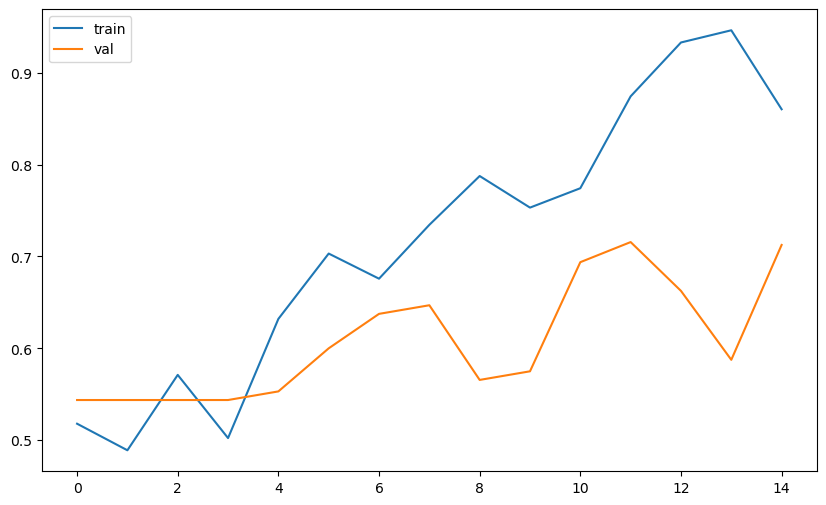

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.6800 - loss: 0.5710
test_loss : 0.5710042715072632 test_acc : 0.6800000071525574


In [317]:
# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss, test_acc = model.evaluate(x_test,y_test)
print(f'test_loss : {test_loss} test_acc : {test_acc}')

In [318]:
# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]

x_sample = tokenizer.texts_to_sequences(sample_texts) #단어사전 기반으로 단어들을 숫자로 변경(길이는 다름)
print(f'단어인덱스 : {tokenizer.word_index}')
print(f'단어카운트 : {tokenizer.word_counts}')
print(f'인덱스워드 : {tokenizer.index_word}')

x_sample = pad_sequences(x_sample, maxlen=maxlen, truncating='post')
x_sample_pedict = model.predict(x_sample)
x_sample_pedict


단어인덱스 : {'UNK': 1, 'the': 2, 'a': 3, 'and': 4, 'of': 5, 'to': 6, 'is': 7, 'in': 8, 'that': 9, 'it': 10, 'as': 11, 'with': 12, 'for': 13, 'his': 14, 'this': 15, 'film': 16, 'but': 17, 'he': 18, 'i': 19, 'on': 20, 'are': 21, 'by': 22, 'be': 23, 'one': 24, 'an': 25, 'not': 26, 'movie': 27, 'who': 28, 'from': 29, 'at': 30, 'was': 31, 'have': 32, 'has': 33, 'her': 34, 'you': 35, 'all': 36, 'they': 37, "it's": 38, 'like': 39, 'so': 40, 'out': 41, 'about': 42, 'up': 43, 'more': 44, 'when': 45, 'which': 46, 'or': 47, 'their': 48, 'what': 49, 'some': 50, 'just': 51, 'if': 52, 'there': 53, 'she': 54, 'him': 55, 'into': 56, 'even': 57, 'only': 58, 'than': 59, 'no': 60, 'time': 61, 'good': 62, 'we': 63, 'most': 64, 'its': 65, 'can': 66, 'will': 67, 'story': 68, 'would': 69, 'been': 70, 'much': 71, 'also': 72, 'get': 73, 'other': 74, 'character': 75, 'do': 76, 'two': 77, 'well': 78, 'them': 79, 'very': 80, 'first': 81, 'characters': 82, 'after': 83, 'see': 84, 'way': 85, 'because': 86, 'make': 87, 

array([[0.93278074],
       [0.932919  ]], dtype=float32)

In [319]:
# Conv1d 배치크기, 시퀀스길이, 채널수
x = tf.random.normal((32,10,64))
print(tf.keras.layers.Flatten()(x).shape)
print(tf.keras.layers.GlobalAvgPool1D()(x).shape) #각 채널 Feature map 마다 평균

(32, 640)
(32, 64)


GlobalMaxPooling 사용(파라메터 감소)
-Flatten 대신 GlobalMaxPooling1D 각 필터의 최대값만 추출해서 파라메터수를 감소
- 토크나이져 - 시퀀스 - 패딩 --> X 라벨링 --> y
- 분할
- 모델... Flatten GlobalMaxPool1D

In [320]:
# nltk 데이터로드
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')
tokenizer.fit_on_texts(reviews)
X = tokenizer.texts_to_sequences(reviews) #단어사전 기반으로 단어들을 숫자로 변경(길이는 다름)

X = pad_sequences(X, maxlen=maxlen, truncating='pre')
print(f'패딩결과 : {padded} 사이즈 : {padded.shape}')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\khh11\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


패딩결과 : [[3 6 2 4 7 0]
 [3 8 4 9 5 0]
 [2 2 1 5 0 0]] 사이즈 : (3, 6)


- 개선2 다중 커널 크기 병렬 적용(TextCNN)
    - 커널 크기 3 5 7 동시에 사용 다양한 tri-gram 5-gram 7-gram 포착

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - acc: 0.5109 - loss: 0.6979 - val_acc: 0.4563 - val_loss: 0.6966
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - acc: 0.7516 - loss: 0.6773 - val_acc: 0.5469 - val_loss: 0.6870
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - acc: 0.8789 - loss: 0.6677 - val_acc: 0.4656 - val_loss: 0.6891
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - acc: 0.7672 - loss: 0.6530 - val_acc: 0.4688 - val_loss: 0.6870
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - acc: 0.9914 - loss: 0.6345 - val_acc: 0.7375 - val_loss: 0.6774
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - acc: 0.9992 - loss: 0.6107 - val_acc: 0.7531 - val_loss: 0.6664
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - acc: 0.9961 - loss: 0.5778 - val_acc: 0.6969 - val_loss: 0.6496
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - acc: 0.9852 - loss: 0.5339 - val_acc: 0.6812 - val_loss: 0.6257
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - acc: 0.9641 - loss: 

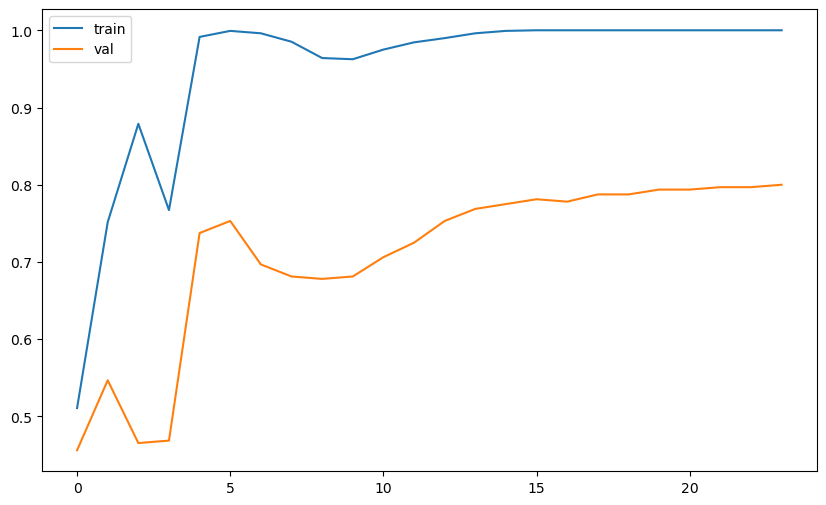

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7950 - loss: 0.4624
test loss : 0.462406724691391  test acc : 0.7950000166893005
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


array([[0.03327638],
       [0.6042185 ]], dtype=float32)

In [321]:
from tensorflow.keras.layers import Input, Concatenate
# 입력레이어
input_layer = Input(shape=(maxlen ,), dtype='int32')
# 임베딩 레이어
embedding = tf.keras.layers.Embedding(max_words+1, embed_dim, input_length = maxlen)(input_layer)
conv_blocks = []
for kerner_size in [3,5,7]:
    conv = tf.keras.layers.Conv1D(128,3,activation='relu')(embedding)
    pool = tf.keras.layers.GlobalMaxPool1D()(conv)
    conv_blocks.append(pool)
# 병렬 브랜치 결함
concat = Concatenate()(conv_blocks)
# 완전연결층
dense = tf.keras.layers.Dense(64,activation='relu')(concat)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

# 모델 생성
model = tf.keras.models.Model(inputs= input_layer, outputs = output)
# 컴파일
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
# 콜백(선택)
es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# 학습
history = model.fit(
    x_train, y_train, epochs =epochs, batch_size=batch_size, validation_split=0.2
    ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict


Pretrained Embeddings(GloVe)로 초기화

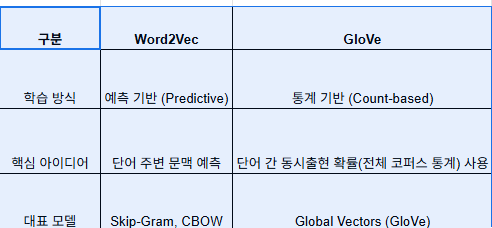

In [322]:
import os
import urllib.request
import zipfile
glove_url = 'https://nlp.stanford.edu/data/glove.6B.zip'
glove_dir = './glove_data'
glove_file = os.path.join(glove_dir, 'glove.6B.100d.txt')

if not os.path.exists(glove_file):
    os.makedirs(glove_dir, exist_ok=True)
    zip_path = os.path.join(glove_dir, 'glove.6B.zip')
    urllib.request.urlretrieve(glove_url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(glove_dir)
    print("다운로드 완료!")

In [323]:
import gensim.downloader as api
import numpy as np

# Glove모델 (50차원)
wv = api.load('glove-wiki-gigaword-50')

In [324]:
# “우리 데이터셋에서 사용되는 단어들”을
#  “GloVe가 이미 학습한 벡터”로 연결해서
# Embedding Laye 의 가중치 초기값으로 사용하기 위해 embedding_matrix를 만드는 것.
wv['king'].shape

(50,)

매칭 : 9722 비매칭 : 277
커버리지 : 0.9722972297229723
Epoch 1/100


c:\Users\khh11\miniconda3\envs\pyt_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - acc: 0.4852 - loss: 0.8185 - val_acc: 0.4563 - val_loss: 0.7747
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - acc: 0.5719 - loss: 0.6855 - val_acc: 0.5437 - val_loss: 0.6905
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - acc: 0.5328 - loss: 0.6861 - val_acc: 0.4563 - val_loss: 0.7123
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - acc: 0.5938 - loss: 0.6592 - val_acc: 0.5625 - val_loss: 0.6810
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - acc: 0.6867 - loss: 0.6498 - val_acc: 0.5813 - val_loss: 0.6840
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - acc: 0.7000 - loss: 0.6345 - val_acc: 0.6156 - val_loss: 0.6774
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - acc: 0.9477 - loss: 0.6174 - val_acc: 0.6187 - val_loss: 0.6740
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - acc: 0.9039 - loss: 0.6007 - val_acc: 0.6156 - val_loss: 0.6679
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - acc: 0.9539 - loss: 0.5

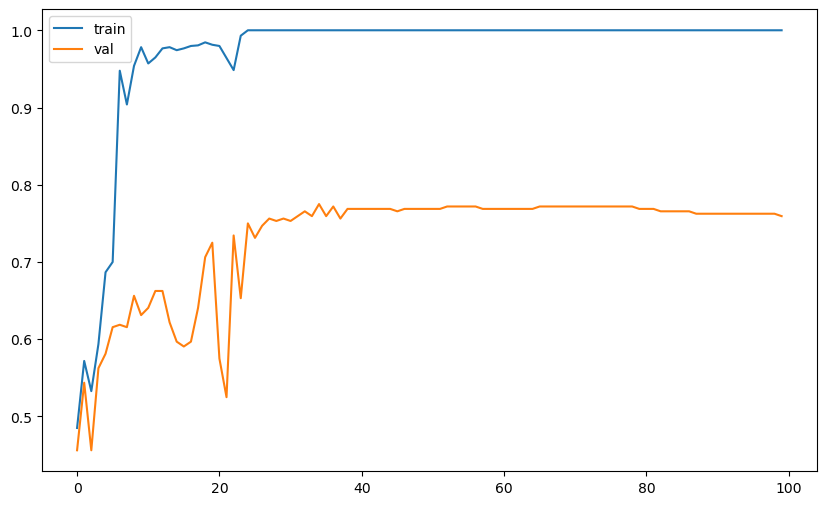

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7875 - loss: 0.5819
test loss : 0.5819268226623535  test acc : 0.7875000238418579
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


array([[0.13007042],
       [0.66407526]], dtype=float32)

In [325]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  # 단어를 단어사전, 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences  #길이 맞추기 

# 하이퍼파라메터
max_words = 10000 # 최대단어수
maxlen = 500 # 문서길이
embed_dim = 50 # 임베딩차원
batch_size = 256 # batch_size
epochs = 15 # epoch

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words,oov_token='UNK')
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(x,maxlen=maxlen,truncating='post')

# 라벨인코딩
label_map = {'pos':0,'neg':1}
y = np.array([label_map.get(c) for c in categories])
# train/test 분할
from sklearn.model_selection import train_test_split
import numpy as np
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y, random_state=42, test_size=0.2)

# 임베딩 매트릭스 초기화
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index)+1)
embedding_matrix = np.random.normal(
    loc = 0.0, scale=0.1,size =(num_words, embed_dim)
)

# glove 매칭
hits = 0
misses = 0
for word, i in word_index.items():
    if i >= max_words:
        continue
    try:
        embedding_vector = wv[word]      # GloVe에서 단어 벡터 찾기
        embedding_matrix[i] = embedding_vector  # 해당 위치에 저장
        hits += 1
    except KeyError:
        misses += 1
print(f'매칭 : {hits} 비매칭 : {misses}')        
print(f'커버리지 : {hits / (hits+misses)}')

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(num_words,output_dim=embed_dim,input_length=maxlen,
                              weights=[embedding_matrix] ),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.MaxPool1D(),  # 시퀀스의 구간별 특징 요약
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),  # 전체시퀀스의 평균  시퀀스차원없애고 채널 축만남김(채널에대한평균)    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=100,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

다중커널(3 5 7) + 드랍아웃 + L2 정규화

Epoch 1/15


c:\Users\khh11\miniconda3\envs\pyt_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step - acc: 0.4906 - loss: 1.0071 - val_acc: 0.4563 - val_loss: 0.9883
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - acc: 0.5258 - loss: 0.9574 - val_acc: 0.4563 - val_loss: 0.9459
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - acc: 0.7039 - loss: 0.9155 - val_acc: 0.6375 - val_loss: 0.9112
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - acc: 0.7797 - loss: 0.8799 - val_acc: 0.4812 - val_loss: 0.8840
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - acc: 0.7625 - loss: 0.8469 - val_acc: 0.4563 - val_loss: 0.8597
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - acc: 0.8211 - loss: 0.8168 - val_acc: 0.5656 - val_loss: 0.8363
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - acc: 0.9000 - loss: 0.7883 - val_acc: 0.6687 - val_loss: 0.8129
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - acc: 0.9211 - loss: 0.7613 - val_acc: 0.6656 - val_loss: 0.7895
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - acc: 0.8547 - loss: 0.7306 - va

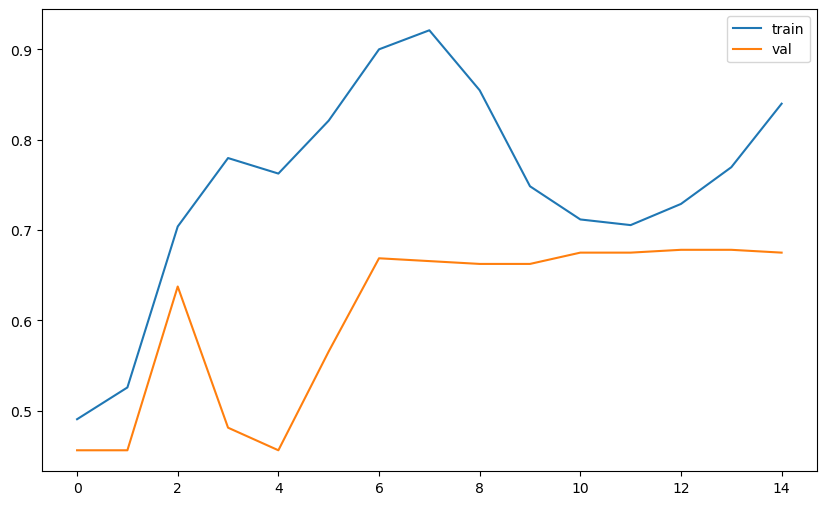

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.6525 - loss: 0.6961
test loss : 0.6960708498954773  test acc : 0.6524999737739563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


array([[0.46089625],
       [0.47153017]], dtype=float32)

In [327]:
from tensorflow.keras.layers import Input, Concatenate
# 입력레이어
input_layer = Input(shape=(maxlen ,), dtype='int32')
# 임베딩 레이어
embedding = tf.keras.layers.Embedding(max_words+1, embed_dim, input_length = maxlen)(input_layer)
conv_blocks = []
for kerner_size in [3,5,7]:
    conv = tf.keras.layers.Conv1D(
        128,
        kerner_size,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-3)
        )(embedding)
    pool = tf.keras.layers.GlobalMaxPool1D()(conv)
    conv_blocks.append(pool)
# 병렬 브랜치 결함
concat = Concatenate()(conv_blocks)
# 완전연결층
dense = tf.keras.layers.Dense(128,activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-3)
                               )(concat)
dense = tf.keras.layers.Dropout(0.5)(dense)
dense = tf.keras.layers.Dense(64,activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-3)
                               )(concat)
dense = tf.keras.layers.Dropout(0.3)(dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

# 모델 생성
model = tf.keras.models.Model(inputs= input_layer, outputs = output)
# 컴파일
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
# 콜백(선택)
es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# 학습
history = model.fit(
    x_train, y_train, epochs =epochs, batch_size=batch_size, validation_split=0.2
    ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

In [ ]:
# %pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from datasets import load_dataset


In [326]:
학습된 모델을 추론해서 결과 보기

개선 아이디어
    GlobalMaxPooling 사용(Flatten 대신) → 파라미터 감소
    다중 커널 크기(3,5,7) 병렬 적용 (TextCNN 구조)
    Pretrained Embeddings (GloVe) 로 초기화
    과적합 방지: Dropout, L2 Regularization
    학습률 스케줄링(Cosine annealing, ReduceLROnPlateau)

SyntaxError: invalid character '→' (U+2192) (3659201011.py, line 4)